In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
# from sklearn import linear_model
from scipy.special import expit
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline
import math
import dateparser
import datetime
one_day = datetime.timedelta(days=1)


In [0]:
def cleanname(name):
        if name[-1]=='-':
            name=name[:-1]
        else:
            name=name
        return name
def pulldata():
    dfo=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    df=dfo
    df['Province/State'].fillna(value='',inplace=True)
    df['site']=df['Country/Region']+'-'+df['Province/State']
    #clean the countries with little data 
    # df=df[df[list(df)[-4]]>0]
    # df=df[df[list(df)[-3]]>0]
    #clean site name to do the filters
    df['site']=df['site'].apply(lambda x: cleanname(x))
    sites=list(df['site'].unique())
    df0=df.groupby(['Country/Region','Province/State','site','Lat','Long']).sum().stack().reset_index()
    df0.rename(columns={'level_5':'date',0:'accumulated'}, inplace=True)
    df0['date']=df0['date'].apply(lambda x:pd.to_datetime(x))
    return sites,df0
sites,df0=pulldata()    

In [0]:
site='Colombia'
df_data=df0[df0['site']==site]
df_data=df_data[df_data.accumulated!=0]
df_data['days']=np.arange(len(df_data.index))+1
df_data=df_data[['site','date','accumulated','days']]
X,Y=np.array(df_data.days).reshape(-1, 1),np.array(df_data.accumulated).reshape(-1, 1)

## PROPHET

In [0]:
from fbprophet import Prophet
import pickle
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [56]:
p0 = np.random.exponential(size=3)

 # Set min bound 0 on all coefficients, and set different max bounds for each coefficient
bounds = (0, [1000000., 100., 1000.])
x,y=np.array(df_data.days),np.array(df_data.accumulated)
(a,b,c),cov = curve_fit(func_logistic, x, y, bounds=bounds, p0=p0, maxfev=100000)
                
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
i_fastest = func_logistic(t_fastest, a, b, c)
                
res_df = df_data[['date', 'accumulated']].copy()
res_df['fastest_grow_day'] = t_fastest
res_df['fastest_grow_value'] = i_fastest
res_df['growth_stabilized'] = t_fastest <= x[-1]
res_df['timestep'] = x
res_df['res_func_logistic'] = func_logistic(x, a, b, c)
            
if t_fastest <= x[-1]:
  print('Growth stabilized:', 'accumulated', '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
  res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
  
else:
  print('Growth increasing:', 'accumulated', '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
  res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)

Growth stabilized: accumulated | Fastest grow day: 20.5879549142902 | Infections: 499.99999999999994


In [0]:
df = res_df[['date', 'accumulated','cap']].dropna()
df.columns = ['ds', 'y','cap']
m = Prophet(growth="logistic")
m.fit(df)
future = m.make_future_dataframe(periods=20)
future['cap'] = df['cap'].iloc[0]
forecast = m.predict(future)
fin_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds').y).reset_index()

In [63]:
df

,ds,y,cap
8954,2020-03-06,1,999.999999
8955,2020-03-07,1,999.999999
8956,2020-03-08,1,999.999999
8957,2020-03-09,1,999.999999
8958,2020-03-10,3,999.999999
8959,2020-03-11,9,999.999999
8960,2020-03-12,9,999.999999
8961,2020-03-13,13,999.999999
8962,2020-03-14,22,999.999999
8963,2020-03-15,34,999.999999


In [62]:
forecast

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-06,233.415293,999.999999,-2666.097569,2572.120863,233.415293,233.415293,-176.776808,-176.776808,-176.776808,-176.776808,-176.776808,-176.776808,0.0,0.0,0.0,56.638485
1,2020-03-07,254.093992,999.999999,-2448.411312,2690.660816,254.093992,254.093992,-96.938296,-96.938296,-96.938296,-96.938296,-96.938296,-96.938296,0.0,0.0,0.0,157.155696
2,2020-03-08,275.945208,999.999999,-2158.254139,2843.449194,275.945208,275.945208,-5.464429,-5.464429,-5.464429,-5.464429,-5.464429,-5.464429,0.0,0.0,0.0,270.480779
3,2020-03-09,298.922491,999.999999,-2326.013957,2983.492372,298.922491,298.922491,69.348982,69.348982,69.348982,69.348982,69.348982,69.348982,0.0,0.0,0.0,368.271473
4,2020-03-10,322.959639,999.999999,-2124.285365,3127.179698,322.959639,322.959639,184.989739,184.989739,184.989739,184.989739,184.989739,184.989739,0.0,0.0,0.0,507.949377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2020-05-15,998.729427,999.999999,-1655.289157,3381.897391,998.729427,998.729427,-176.776808,-176.776808,-176.776808,-176.776808,-176.776808,-176.776808,0.0,0.0,0.0,821.952619
71,2020-05-16,998.864160,999.999999,-1545.092417,3448.374598,998.864160,998.864160,-96.938296,-96.938296,-96.938296,-96.938296,-96.938296,-96.938296,0.0,0.0,0.0,901.925864
72,2020-05-17,998.984620,999.999999,-1585.422510,3420.633341,998.984620,998.984620,-5.464429,-5.464429,-5.464429,-5.464429,-5.464429,-5.464429,0.0,0.0,0.0,993.520191
73,2020-05-18,999.092317,999.999999,-1414.218945,3557.881733,999.092317,999.092317,69.348982,69.348982,69.348982,69.348982,69.348982,69.348982,0.0,0.0,0.0,1068.441299


## NEURAL NETWORK


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


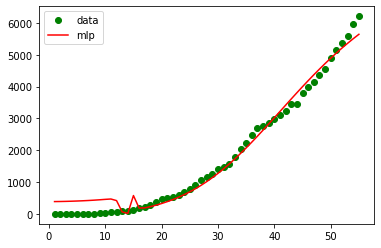

In [44]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(hidden_layer_sizes = (4,4), activation = 'tanh', solver = 'lbfgs') 
reg.fit(X, Y) 
puntos = plt.plot(X, Y, 'o', color='green', label = "data")
curva_regresion = plt.plot(X, reg.predict(X), color='red', label = "mlp")
plt.legend()
plt.show()

In [0]:


Y_pred = reg.predict(X)
df['Y_pred'] = Y_pred
df['Difference'] = df.Bandgap - df.Y_pred

Country/Region            object
Province/State            object
site                      object
Lat                      float64
Long                     float64
date              datetime64[ns]
accumulated                int64
dtype: object